In [1]:
import sys
from cProfile import label

sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
Load relevant packages
"""

# numpy for vector and matrix calculations + simulation
import numpy as np

# pandas
import pandas as pd

# import statistics function from scipy
from scipy import stats

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# yfinance and pandas datareader for data
import yfinance as yf
from pandas_datareader import data as wb

# packages for working with dates and time
import datetime


"""
Own packages
"""

# function for loading FRED nominal yield curve data
from codelib.dal.fred_yield_data import get_nominal_yield_data

# set default style
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Modelling Financial Markets: Risk drivers and invariants

## Risk driver identification

### Equities

In [2]:
"""
Download SP500 adj. closing prices since 1990
"""

sp500 = yf.download('^GSPC',start=datetime.date(1990, 1, 1))
sp500.head()

C:\Users\johan\AppData\Local\Temp\ipykernel_15508\2061206112.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC',start=datetime.date(1990, 1, 1))
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1990-01-02,359.690002,359.690002,351.980011,353.399994,162070000
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000


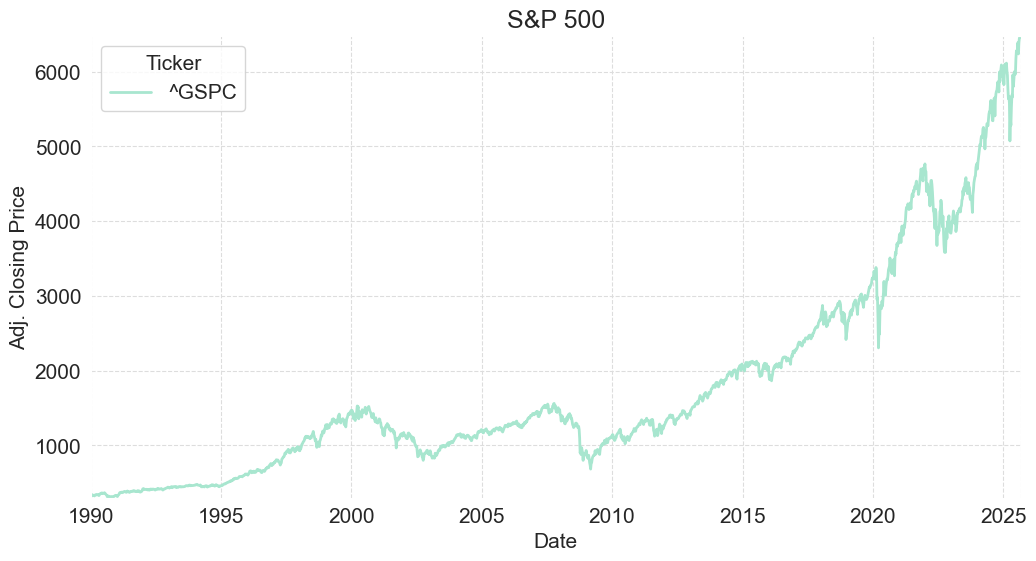

In [6]:
"""
Resample at weekly frequency and plot price development
"""

fig, ax = plt.subplots(figsize=(12, 6))

sp500_adj_close_weekly = sp500['Close'].resample('W').last()
sp500_adj_close_weekly.plot(title="S&P 500", ylabel="Adj. Closing Price", figsize=(12, 6), ax=ax)

plt.show()

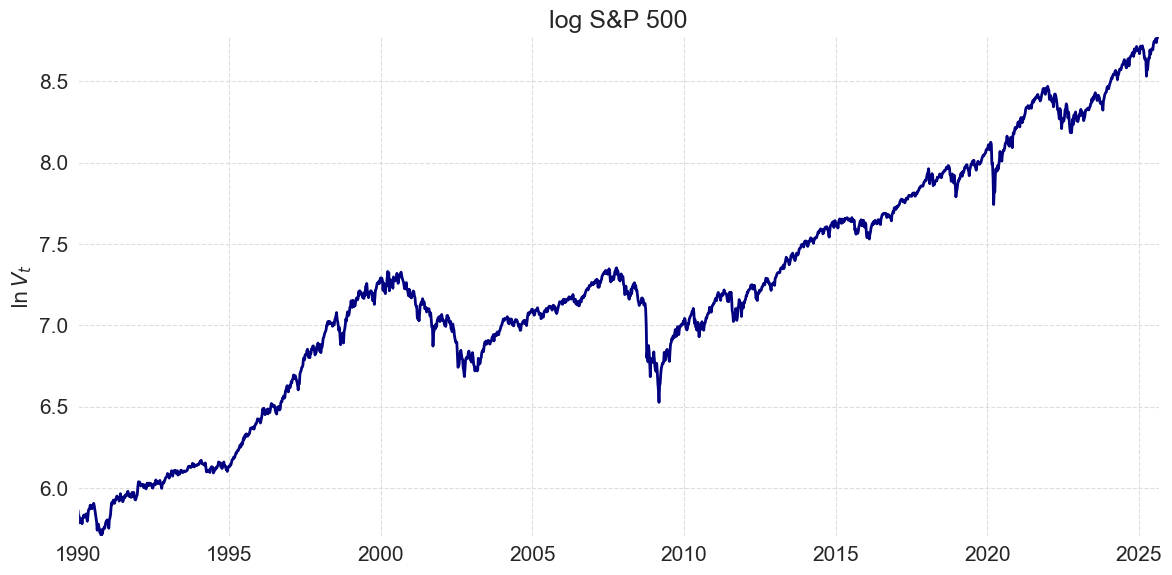

In [12]:
"""
Plot log-value
"""

fig, ax = plt.subplots(figsize=(12, 6))

np.log(sp500_adj_close_weekly).plot(title="log S&P 500", ylabel="$\\ln V_t$", figsize=(12, 6), ax=ax, legend=False, color="navy")

ax.set_xlabel('')
plt.tight_layout()

plt.savefig('logSP500.png', dpi=300)

plt.show()

### Fixed Income

#### Value cannot be used as risk driver

In [14]:
"""
Get zero yield data, resample monthly
"""

zero_yields = get_nominal_yield_data(output_type='zero_yields').resample('ME').last()
tenors = np.arange(1, 31, 1)

"""
Define step size
"""
dt = 1.0 / 12.0

"""
Define function to calculate zero coupon price
"""

def calculate_zero_coupon_price(ttm: float, ytm: float):

    """
    Function that calculates price of a zero coupon bond given time to maturity
    and zero yield

    Parameters
    ----------
    ttm:
        Time to maturity
    ytm:
        Yield to maturity

    Returns
    -------
    float
        Zero coupon bond price

    """

    price = np.exp(-ttm * ytm)

    return price

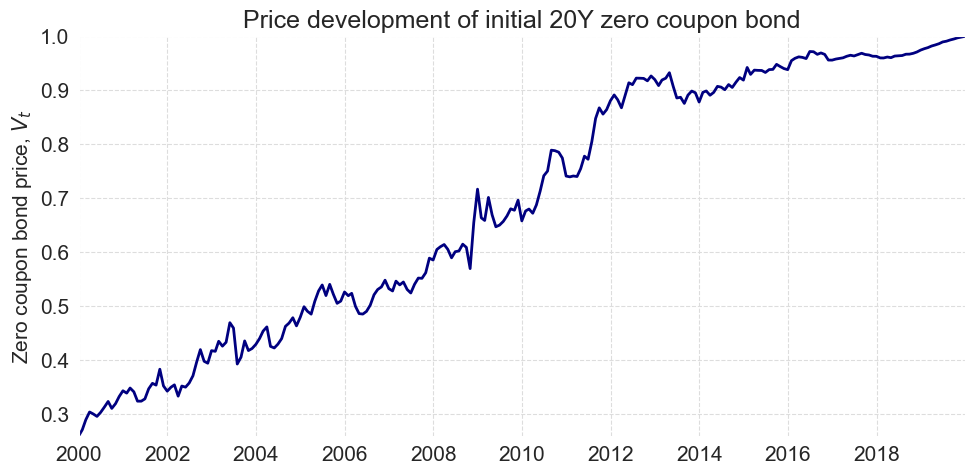

In [22]:
# import an interpolation function - we will talk more about this later
from scipy.interpolate import splev, splrep

"""
Look at the price development of a 20Y zero coupon bond from 1999-12-31 to 2019-12-31.

Do not think to much about these calculation - we will look more into this later
"""

zero_yields_sample = zero_yields["1999-12-31":"2019-12-31"] / 100

time_to_maturity = np.arange(20.0, -0.01, -dt)
zero_coupon_prices = np.empty_like(time_to_maturity)

for i, t in enumerate(time_to_maturity):
    zero_curve_spline = splrep(tenors, zero_yields_sample.iloc[i, :].values)
    zero_coupon_prices[i] = calculate_zero_coupon_price(t, splev(t, zero_curve_spline))


"""
Plot price development
"""
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(zero_yields_sample.index, zero_coupon_prices, color="navy")
ax.set_title('Price development of initial 20Y zero coupon bond')
ax.set_ylabel('Zero coupon bond price, $V_t$');

plt.tight_layout()
plt.savefig('zcb_20y_price_development.png', dpi=300)

plt.show()

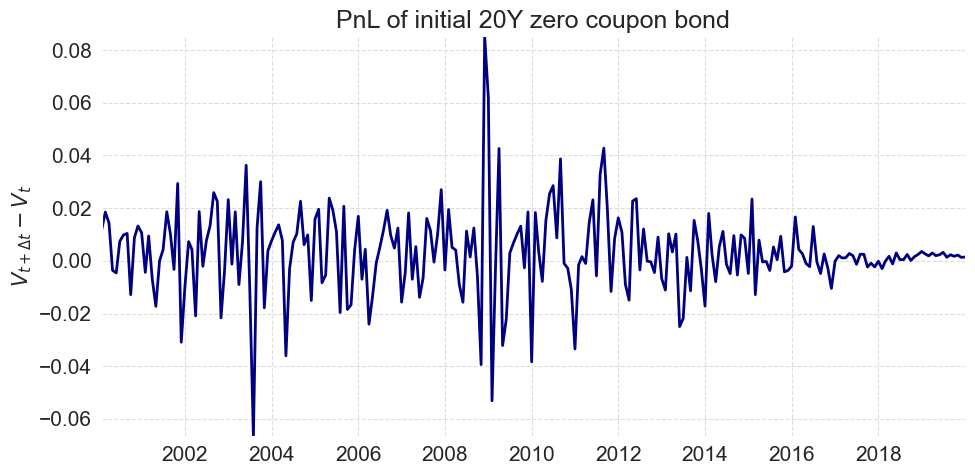

In [23]:
zc_gross_return = zero_coupon_prices[1:] - zero_coupon_prices[:-1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(zero_yields_sample.index[1:], zc_gross_return, color="navy")
ax.set_title('PnL of initial 20Y zero coupon bond')
ax.set_ylabel('$V_{t + \\Delta t} - V_t$')

plt.tight_layout()
plt.savefig('zcb_20y_pnl.png', dpi=300)

plt.show()

#### Proper risk drivers

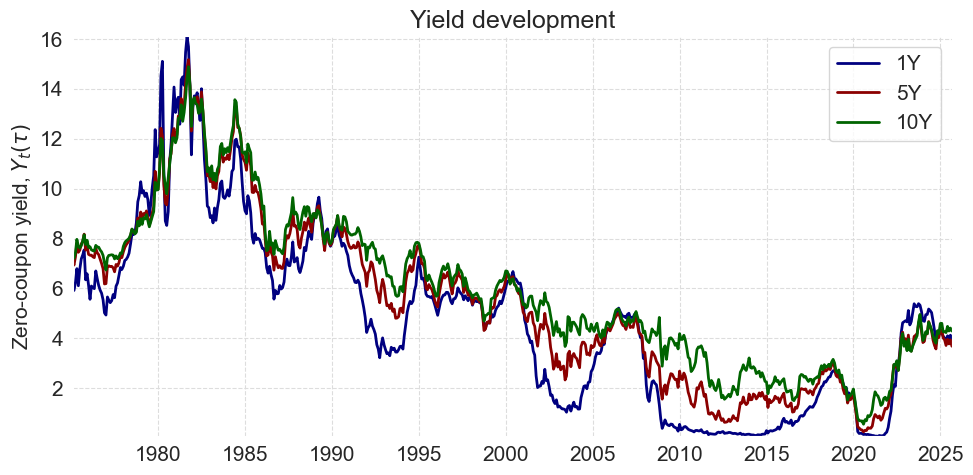

In [37]:
start_date = '1975-01-01'
zero_yields_sample = zero_yields[start_date:]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(zero_yields_sample.index[:], zero_yields_sample.loc[:, 'SVENY01'], color="navy", label='1Y')
ax.plot(zero_yields_sample.index[:], zero_yields_sample.loc[:, 'SVENY05'], color="darkred", label='5Y')
ax.plot(zero_yields_sample.index[:], zero_yields_sample.loc[:, 'SVENY10'], color="darkgreen", label='10Y')
ax.set_title('Yield development')
ax.set_ylabel('Zero-coupon yield, $Y_t(\\tau)$')

ax.legend()

plt.tight_layout()
plt.savefig('key_rates_as_risk_drivers.png', dpi=300)

plt.show()

In [39]:
"""
Download nominal yield curve parameters, resample monthly
"""
ns_parameters = get_nominal_yield_data(output_type='parameters').resample('ME').last()

In [40]:
ns_parameters.head()

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Date,,,,,,
1961-06-30,4.030149,-1.286785,-1.946674,0.0,0.493864,-999.99
1961-07-31,4.259235,-2.173604,-0.990919,0.0,0.743020,-999.99
1961-08-31,4.241705,-1.427809,-2.124631,0.0,0.507521,-999.99
1961-09-30,4.060776,-1.727077,-1.026013,0.0,0.575366,-999.99
1961-10-31,4.151372,-1.812799,0.422462,0.0,1.591745,-999.99


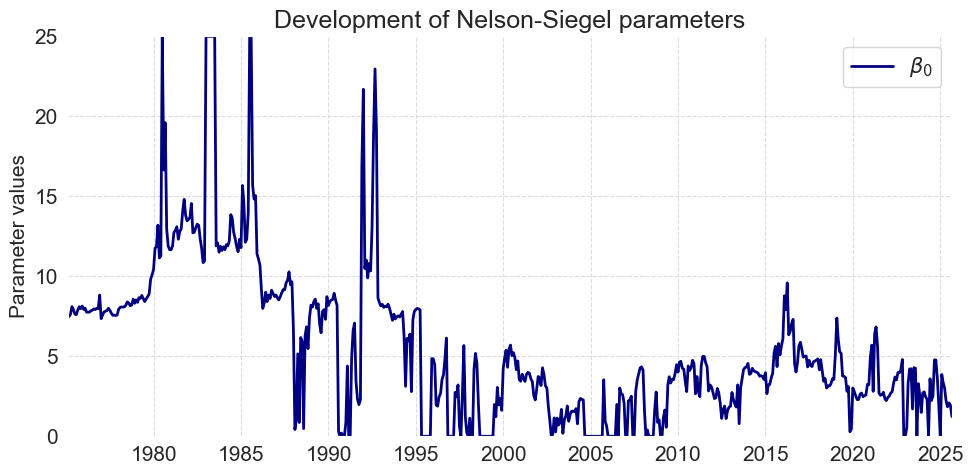

In [45]:
start_date = '1975-01-01'
ns_parameters_sample = ns_parameters[start_date:]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ns_parameters_sample.index[:], ns_parameters_sample.loc[:, 'BETA0'], color="navy", label='$\\beta_0$')
#ax.plot(ns_parameters_sample.index[:], ns_parameters_sample.loc[:, 'BETA1'], color="darkred", label='5Y')
#ax.plot(ns_parameters_sample.index[:], ns_parameters_sample.loc[:, 'BETA2'], color="darkgreen", label='10Y')
ax.set_title('Development of Nelson-Siegel parameters')
ax.set_ylabel('Parameter values')

ax.legend()

plt.tight_layout()
plt.savefig('nelson_siegel_as_risk_drivers.png', dpi=300)

plt.show()

## Invariants

### Equities

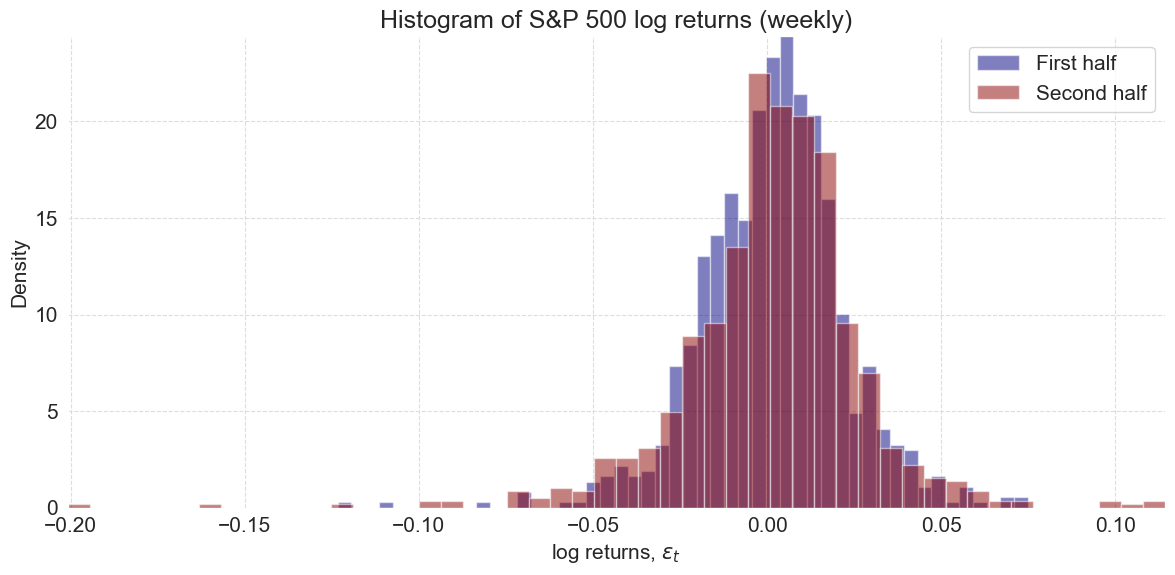

In [57]:
sp500_log_return_weekly = np.log(sp500_adj_close_weekly) - np.log(sp500_adj_close_weekly).shift(1).dropna()

"""
Histogram of sample split in two
"""

half_point = int(len(sp500_log_return_weekly) / 2)

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sp500_log_return_weekly.iloc[0:half_point], alpha=0.5, label="First half", bins=50, density=True, color="navy")
ax.hist(sp500_log_return_weekly.iloc[half_point:-1], alpha=0.5, label="Second half", bins=50, density=True, color="darkred")
ax.legend()
ax.set_title("Histogram of S&P 500 log returns (weekly)")
ax.set_xlabel("log returns, $\\varepsilon_t$")
ax.set_ylabel("Density")

plt.tight_layout()
plt.savefig('sp500_split_sample_hist.png', dpi=300)

plt.show()

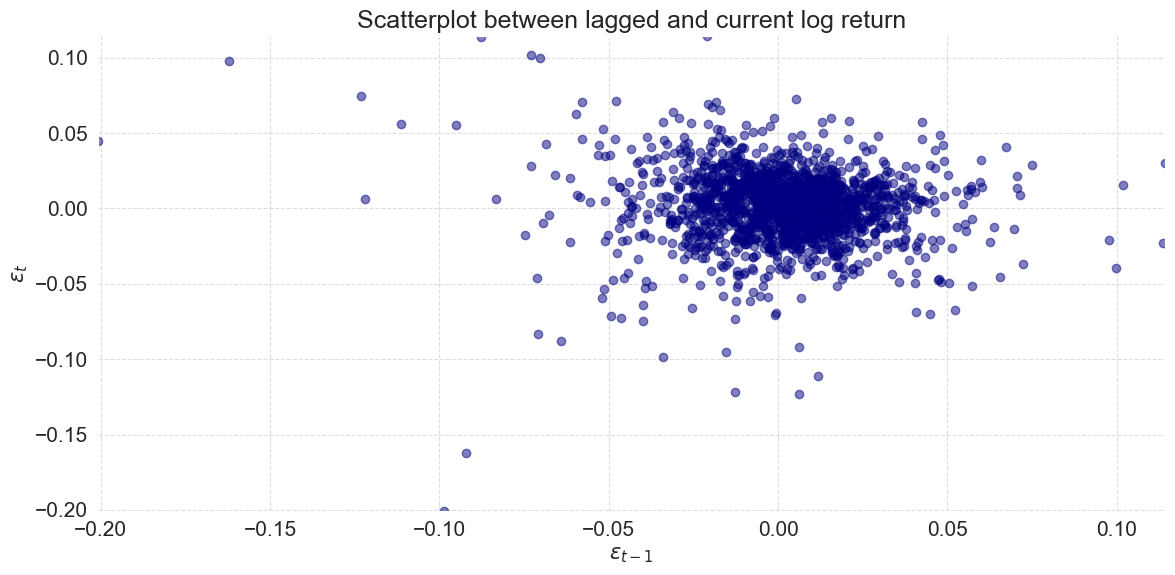

In [65]:
"""
Plot a scatter plot between the price lagged one month and the price
"""

fig, ax = plt.subplots(figsize=(12, 6))
pd.plotting.lag_plot(sp500_log_return_weekly, alpha=0.5, ax=ax, c="navy") # using pandas functionality
ax.set_xlabel('$\\varepsilon_{t-1}$')
ax.set_ylabel('$\\varepsilon_{t}$')
ax.set_title('Scatterplot between lagged and current log return')

plt.tight_layout()
plt.savefig('sp500_scatter_lag_plot.png', dpi=300)

plt.show()

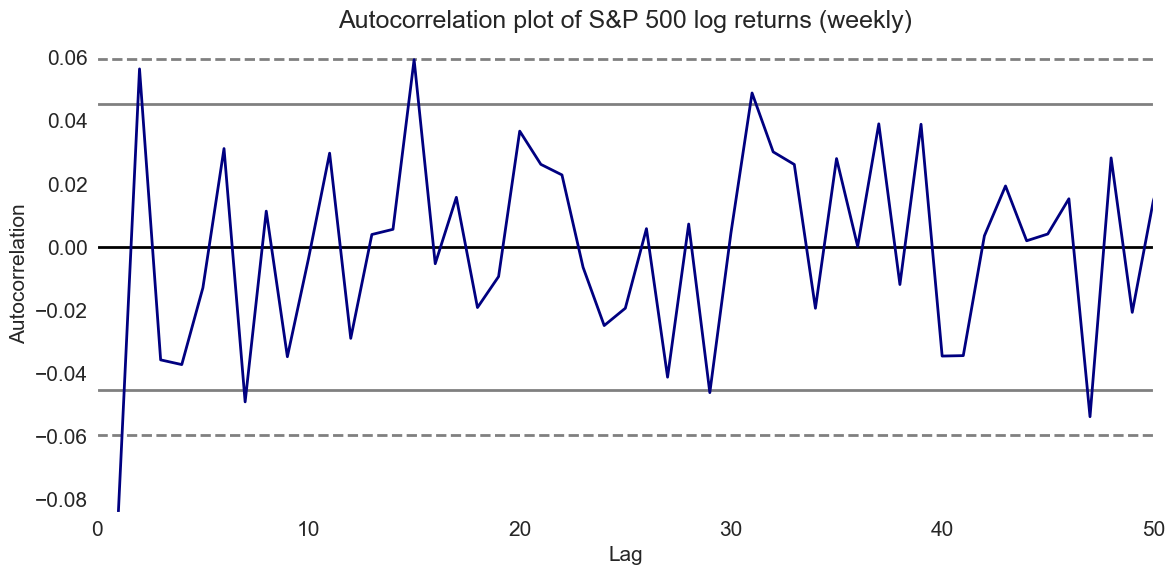

In [71]:
"""
No significant serial correlation!
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax = pd.plotting.autocorrelation_plot(sp500_log_return_weekly.dropna(), ax=ax, color="navy")
ax.set_xlim([0, 50]);

ax.set_title('Autocorrelation plot of S&P 500 log returns (weekly)')

plt.tight_layout()
plt.savefig('sp500_autocorrelation.png', dpi=300)

plt.show()

### Volatility clustering

In [105]:
"""
Download SP500 adj. closing prices since 1990
"""

sp500 = yf.download('^GSPC',start=datetime.date(1990, 1, 1))
sp500.head()

C:\Users\johan\AppData\Local\Temp\ipykernel_15508\2061206112.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC',start=datetime.date(1990, 1, 1))
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1990-01-02,359.690002,359.690002,351.980011,353.399994,162070000
1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000
1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000
1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000
1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000


In [106]:
"""
Obtain daily log returns
"""

log_returns = (np.log(sp500['Close']/sp500['Close'].shift(1))).dropna()

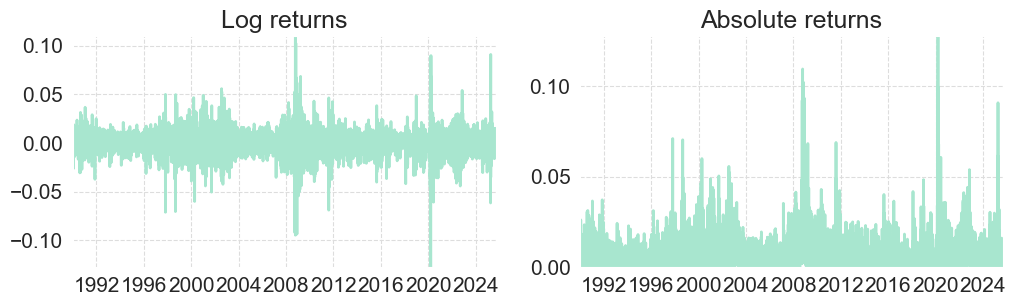

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(log_returns)
ax[0].set_title("Log returns")

ax[1].plot(np.abs(log_returns))
ax[1].set_title("Absolute returns");
plt.show()

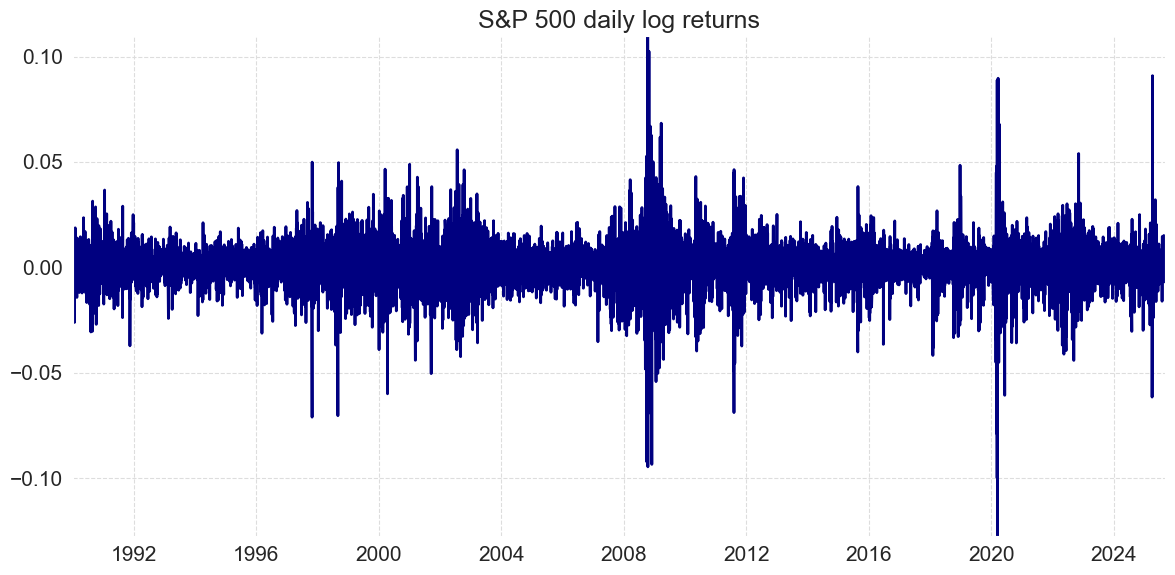

In [115]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(log_returns, color="navy")
ax.set_title("S&P 500 daily log returns")

plt.tight_layout()
plt.savefig('sp500_daily_log_returns.png', dpi=300)

plt.show()


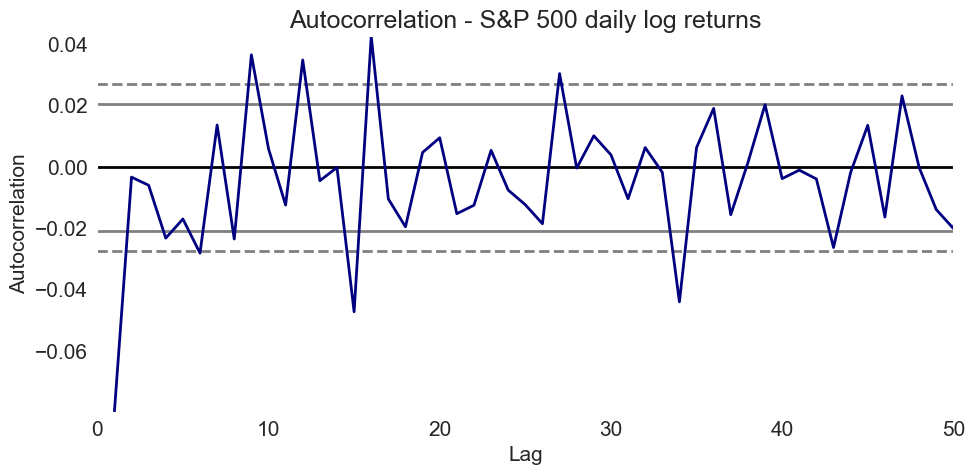

In [116]:
"""
No autocorrelation is log-returns
"""


fig, ax = plt.subplots(figsize=(10, 5))
ax = pd.plotting.autocorrelation_plot(log_returns, ax=ax, color="navy")
ax.set_xlim([0, 50])

ax.set_title("Autocorrelation - S&P 500 daily log returns")

plt.tight_layout()
plt.savefig('sp500_daily_log_returns_autocorrelation.png', dpi=300)

plt.show()

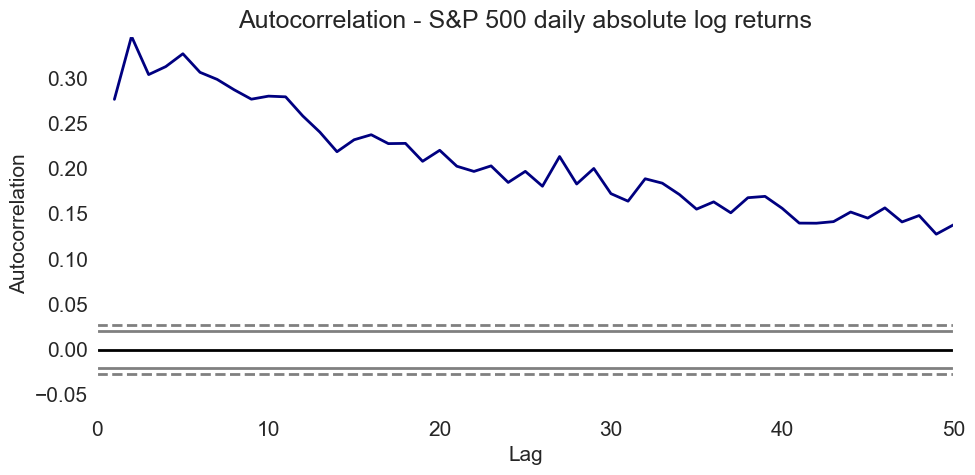

In [117]:
"""
Clear positive autocorrelation is absolute log-returns -> volatility clusttering
"""

fig, ax = plt.subplots(figsize=(10, 5))
ax = pd.plotting.autocorrelation_plot(np.abs(log_returns), ax=ax, color="navy")
ax.set_xlim([0, 50])

ax.set_title("Autocorrelation - S&P 500 daily absolute log returns")

plt.tight_layout()
plt.savefig('sp500_daily_abs_log_returns_autocorrelation.png', dpi=300)

plt.show()

In [101]:
"""
Fit GARCH model
"""

from arch import arch_model
am = arch_model(log_returns * 100, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3716675888.684961
Iteration:      2,   Func. Count:     16,   Neg. LLF: 5007802272.359331
Iteration:      3,   Func. Count:     23,   Neg. LLF: 17061.43929927738
Iteration:      4,   Func. Count:     30,   Neg. LLF: 12064.765803221959
Iteration:      5,   Func. Count:     36,   Neg. LLF: 22735.28572027466
Iteration:      6,   Func. Count:     42,   Neg. LLF: 11977.37579876593
Iteration:      7,   Func. Count:     48,   Neg. LLF: 11961.09422428799
Iteration:      8,   Func. Count:     54,   Neg. LLF: 11960.839564086207
Iteration:      9,   Func. Count:     59,   Neg. LLF: 11960.835310720733
Iteration:     10,   Func. Count:     64,   Neg. LLF: 11960.83529526033
Iteration:     11,   Func. Count:     68,   Neg. LLF: 11960.83529526585
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11960.83529526033
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations:

In [22]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11619.1
Distribution:                  Normal   AIC:                           23246.2
Method:            Maximum Likelihood   BIC:                           23274.5
                                        No. Observations:                 8740
Date:                Thu, Sep 12 2024   Df Residuals:                     8739
Time:                        20:43:12   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0606  8.520e-03      7.108  1.178e-12 [4.

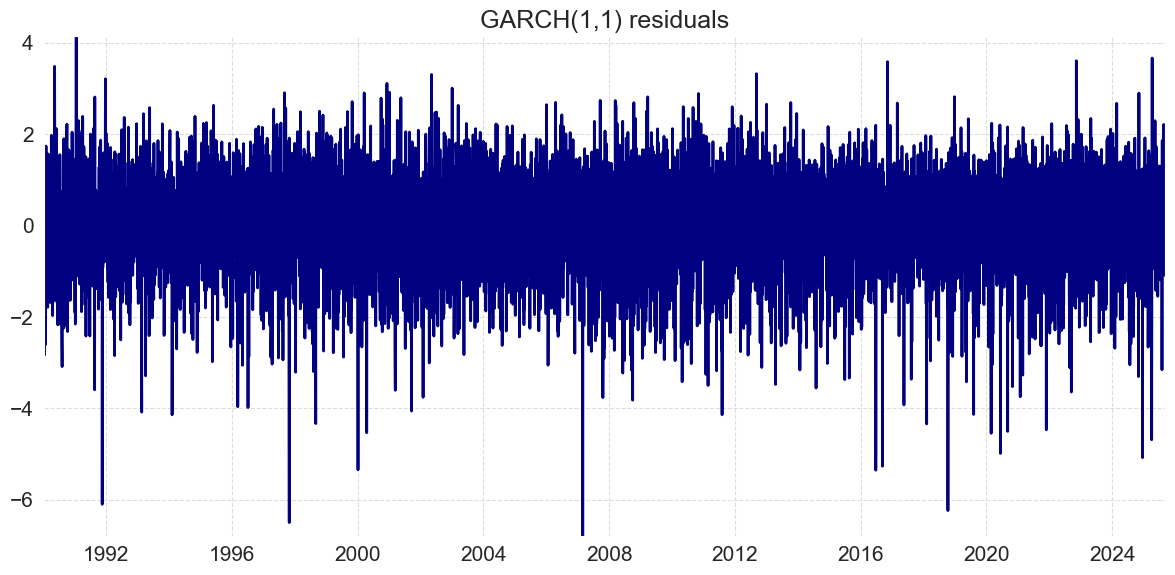

In [125]:
"""
Residuals from GARCH model looking more like invariants!
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(res.std_resid, color="navy")
ax.set_title("GARCH(1,1) residuals");

plt.tight_layout()
plt.savefig('sp500_daily_garch_resids.png', dpi=300)

plt.show()

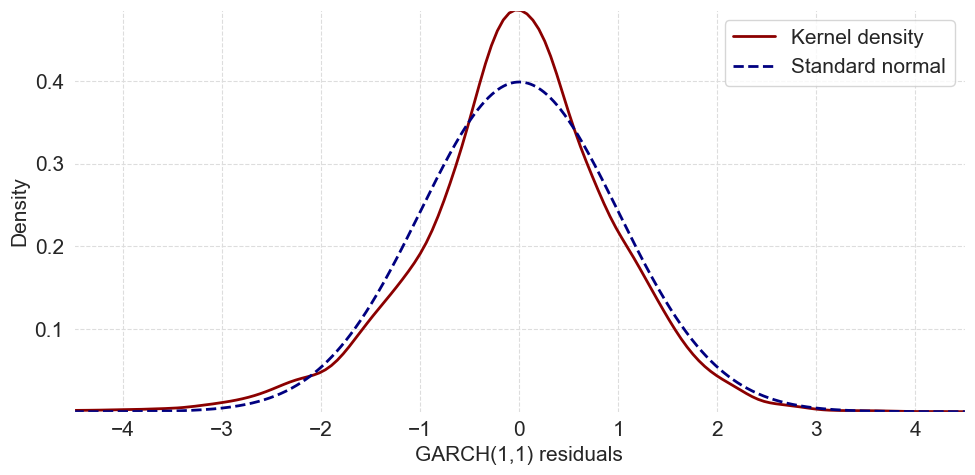

In [126]:
x_vals = np.linspace(-4.5, 4.5, 1000)
pdf_vals = stats.norm.pdf(x_vals)

fig,ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(res.std_resid, ax = ax, color="darkred", label="Kernel density")
ax.plot(x_vals, pdf_vals, color="navy", linestyle="--", label="Standard normal")
ax.set(xlabel="GARCH(1,1) residuals", ylabel="Density")
ax.legend();

ax.set_xlim([-4.5, 4.5])

plt.tight_layout()
plt.savefig('sp500_daily_garch_resids_dist.png', dpi=300)

plt.show()